# Problem 1: Importance Sampling

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Fit a model to the data using:
a. Uniform priors on all parameters
b. Modestly informative Gaussian priors on all parameters
c. Strongly informative Gaussian priors on all parameters

Draw samples from the posterior using any sampler of your choosing.

After sampling in cases (b) and (c), calculate importance weights and resample your posteriors in order to "undo" the informative prior. This step will create a vector of unweighted posterior samples from your original vector of weighted posterior samples. Verify that after importance sampling your results are equivalent to what you obtained in case (a).

Examine the posterior distributions. Do you see any numerical noise or other sampling artifacts introduced by importance sampling?

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

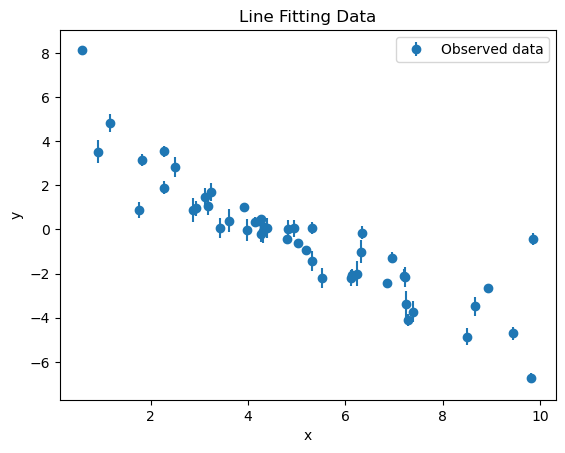

In [10]:
data = pd.read_csv('../Day3/line_fitting.csv')
x_obs = data['x'].values
y_obs = data['y'].values
y_obs_unc = data['y_err'].values 

plt.errorbar(x_obs, y_obs, yerr=y_obs_unc, fmt='o', label='Observed data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Fitting Data')
plt.legend()
plt.show()

In [20]:
import emcee

def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model_y = m * x + b
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2)

def log_prior(theta):
    m, b = theta
    if -10 < m < 10 and -10 < b < 10:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

ndim = 2
nwalkers = 32
np.random.seed(42)
initial = np.random.uniform(-5, 5, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(x_obs, y_obs, y_obs_unc)
)
sampler.run_mcmc(initial, 2000, progress=True)

samples_uniform = sampler.get_chain(discard=500, flat=True)

100%|██████████| 2000/2000 [00:03<00:00, 635.90it/s]


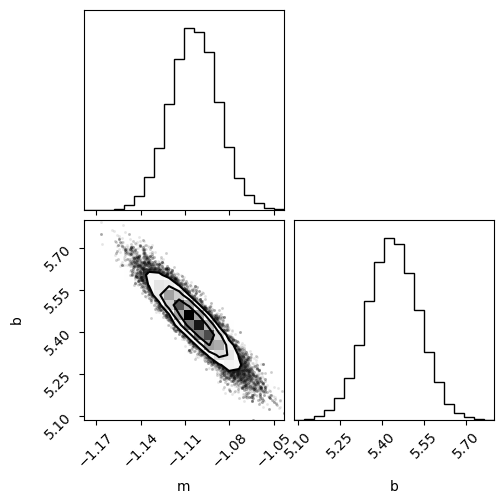

In [ ]:
import corner
fig = corner.corner(samples_uniform, labels=["m", "b"])
plt.show()

In [ ]:
def log_prior_modest(theta):
    m, b = theta
    lp_m = -0.5 * ((m - 0) / 3) ** 2 - np.log(3 * np.sqrt(2 * np.pi))
    lp_b = -0.5 * ((b - 0) / 3) ** 2 - np.log(3 * np.sqrt(2 * np.pi))
    return lp_m + lp_b

def log_posterior_modest(theta, x, y, yerr):
    lp = log_prior_modest(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

sampler_modest = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_modest, args=(x_obs, y_obs, y_obs_unc)
)
sampler_modest.run_mcmc(initial, 2000, progress=True)
samples_modest = sampler_modest.get_chain(discard=500, flat=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:03<00:00, 527.14it/s]


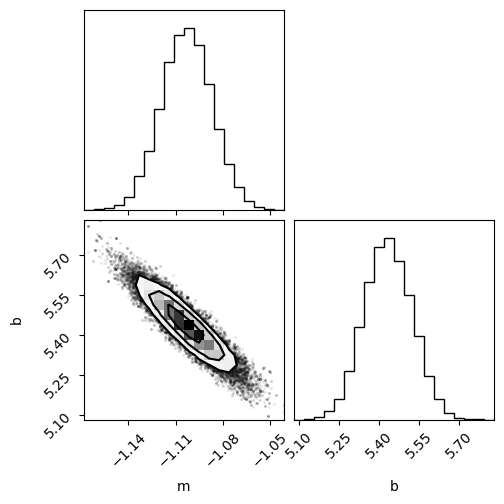

In [ ]:
fig_modest = corner.corner(samples_modest, labels=["m", "b"], truths=[0.5, 1.0])
plt.show()

In [41]:
def log_prior_strong(theta):
    m, b = theta
    lp_m = -0.5 * ((m - 7) / 0.5) ** 2 - np.log(0.5 * np.sqrt(2 * np.pi))
    lp_b = -0.5 * ((b - 7) / 0.5) ** 2 - np.log(0.5 * np.sqrt(2 * np.pi))
    return lp_m + lp_b

def log_posterior_strong(theta, x, y, yerr):
    lp = log_prior_strong(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

sampler_strong = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_strong, args=(x_obs, y_obs, y_obs_unc)
)
sampler_strong.run_mcmc(initial, 2000, progress=True)
samples_strong = sampler_strong.get_chain(discard=500, flat=True)

100%|██████████| 2000/2000 [00:04<00:00, 456.42it/s]


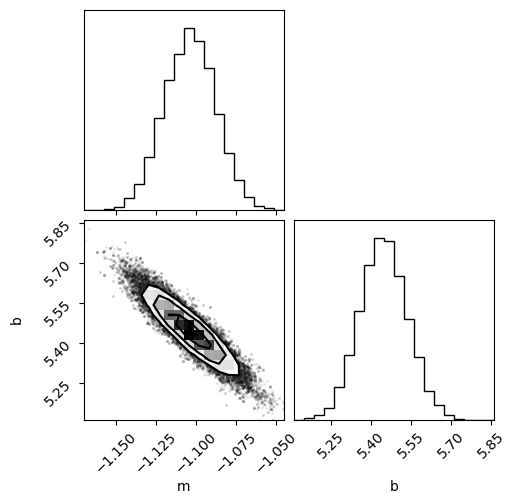

In [42]:
fig_strong = corner.corner(samples_strong, labels=["m", "b"], truths=[0.5, 1.0])
plt.show()

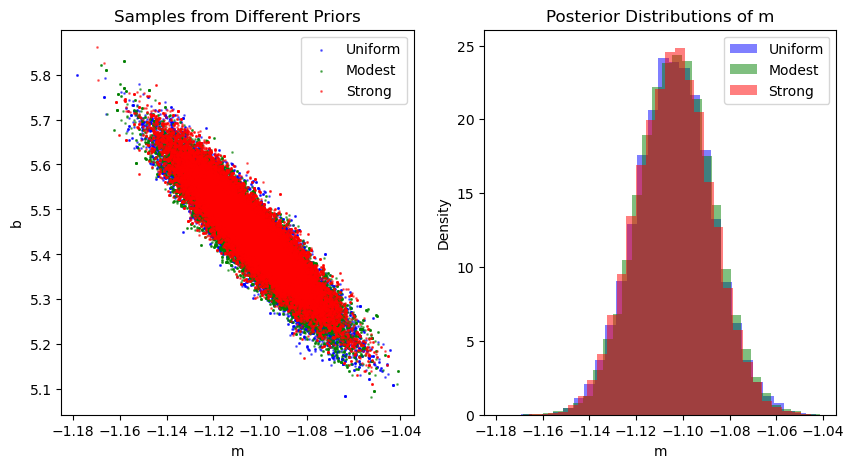

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(samples_uniform[:, 0], samples_uniform[:, 1], s=1, color='blue', alpha=0.5, label='Uniform')    
axes[0].scatter(samples_modest[:, 0], samples_modest[:, 1], s=1, color='green', alpha=0.5, label='Modest')
axes[0].scatter(samples_strong[:, 0], samples_strong[:, 1], s=1, color='red', alpha=0.5, label='Strong')
axes[0].set_xlabel('m')
axes[0].set_ylabel('b')
axes[0].set_title('Samples from Different Priors')
axes[0].legend()
axes[1].hist(samples_uniform[:, 0], bins=30, color='blue', alpha=0.5, label='Uniform', density=True)
axes[1].hist(samples_modest[:, 0], bins=30, color='green', alpha=0.5, label='Modest', density=True)
axes[1].hist(samples_strong[:, 0], bins=30, color='red', alpha=0.5, label='Strong', density=True)
axes[1].set_xlabel('m')
axes[1].set_ylabel('Density')
axes[1].set_title('Posterior Distributions of m')
axes[1].legend()


# Problem 2: Umbrella Sampling Tutorial

Work through the umbrella sampling tutorial here: https://gjgilbert.github.io/tutorials/umbrella_sampling/

Once you complete the tutorial, return to the Line Fitting dataset from Problem 1. Fit a model using umbrella sampling. You'll need to choose how to define your umbrella windows and biases - there are many possible solutions! After sampling from individual umbrellas, combine your samples into a single set of posterior samples. Verify that the results you obtain from umbrella sampling are equivalent to the results you obtain from other methods.

# Problem 3: Reparameterizing a Model

Read in the Two Component Sinusoid dataset (two_component_sinusoid.csv) and plot the data.

Fit a model using the most "obvious" parameterization:

$y(x) = A_1 \sin(2\pi f_1 x - \phi_1 + A_2 \sin(2\pi f_2 x - \phi_2)$

Place appropriate independent priors on each of the six free parameters. Try fitting a model, drawing samples using a sampler of your choosing. Check for convergence and assess the quality of your results. Re-run your model a few times and check if your results remain consistent from run-to-run.

You will probably not acheive a very good fit using this parameterization. Why is this parameterization problematic? Re-parameterize the model in order to get a more robust fit. Check for convergence and that your posteriors remain consistent from run-to-run.